# Doing Bayesian Data Analysis

An example from __Chapter 18__.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

# Kruschke's light blue color
sns.set_palette(["#87ceeb"])
sns.set_context("talk")

In [3]:
df = pd.read_csv("data/18_03_shrinkage.csv")
print len(df)
df.head()

50


,State,Spend,StuTeaRat,Salary,PrcntTake,SATV,SATM,SATT,xRand1,xRand2,xRand3,xRand4,xRand5,xRand6,xRand7,xRand8,xRand9,xRand10,xRand11,xRand12
0,Alabama,4.405,17.2,31.144,8,491,538,1029,-0.207901,0.975430,0.697160,-0.461373,-0.372393,-0.586951,0.997585,-0.038980,-0.048534,0.822558,-0.211743,-0.074761
1,Alaska,8.963,17.6,47.951,47,445,489,934,0.037859,-0.263789,-1.292952,-0.467127,0.837334,-0.171516,0.234234,0.032623,-0.384194,-0.780150,-1.644033,0.122416
2,Arizona,4.778,19.3,32.175,27,448,496,944,-0.824948,-0.352708,-2.002454,0.131457,0.228556,0.426742,-0.007733,-0.618603,-0.329469,-1.169190,-1.090921,0.338399
3,Arkansas,4.459,17.1,28.934,6,482,523,1005,-0.302172,-1.623399,1.340380,0.810939,-0.237945,1.281103,-1.897800,-0.054399,2.262594,1.764555,0.189464,0.780980
4,California,4.992,24.0,41.078,45,417,485,902,0.211717,0.459005,-0.325939,0.213267,-0.683693,1.286049,-0.550715,0.611201,0.282367,-0.157777,0.362889,-0.418922


In [15]:
cols = ["Spend", "PrcntTake", "xRand1", "xRand2", "xRand3", "xRand4", "xRand5",
        "xRand6", "xRand7", "xRand8", "xRand9", "xRand10", "xRand11", "xRand12"]
X = df[cols]
y = df["SATT"]

# A little bit convoluted with the two columns
zx = ((X - X.mean().values) / X.std().values).values
zy = (y - y.mean()) / y.std()

n_cols = len(cols)

In [22]:
with pm.Model() as model:
    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, sd=2)
    beta_j = pm.Normal("beta_j", mu=0, sd=2, shape=n_cols)
    delta_j = pm.Bernoulli("delta_j", 0.5, shape=n_cols)

    theta = beta_0 + tt.dot(delta_j * beta_j, zx.T)

    nu = pm.Gamma("nu", 2, .1)          # Stan docs recommendation
    sigma = pm.HalfCauchy("sigma", 25)  # Gelman 2006

    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=theta, sd=sigma, observed=zy)
    
    # Sample
    step_1 = pm.BinaryGibbsMetropolis([delta_j])
    step_2 = pm.Metropolis([beta_0, beta_j, theta, nu, sigma, y])
    trace = pm.sample(10000, [step_1, step_2])
    
burn_in = 5000
trace = trace[burn_in:]

100%|██████████| 10000/10000 [00:17<00:00, 579.81it/s]


                  mean         sd  mc_error   hpd_2.5   hpd_97.5
beta_0        0.002518   0.059992  0.001684 -0.105702   0.128647
beta_j__0     0.375160   0.478275  0.046965  0.043178   1.782028
beta_j__1    -0.998588   0.094390  0.006341 -1.165316  -0.800139
beta_j__2     0.419367   0.674549  0.065737 -0.839213   1.693333
beta_j__3     0.893371   1.431991  0.142501 -1.316084   3.250158
beta_j__4     0.820175   1.363375  0.135386 -1.990527   3.085353
beta_j__5    -2.838958   1.512188  0.150410 -5.897523  -0.462391
beta_j__6     0.738026   0.909494  0.089574 -0.788881   2.476530
beta_j__7    -0.583806   1.399989  0.139300 -2.325706   1.985446
beta_j__8     3.739660   0.653104  0.063321  2.137339   4.781707
beta_j__9    -0.183794   1.847428  0.184123 -3.750018   2.200379
beta_j__10   -0.142826   1.429194  0.142225 -2.701582   2.391888
beta_j__11    0.539959   1.011112  0.100218 -0.583089   2.693053
beta_j__12    0.443697   1.060625  0.104953 -1.381680   2.098845
beta_j__13    0.279473   

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fd34850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13d05e250>]], dtype=object)

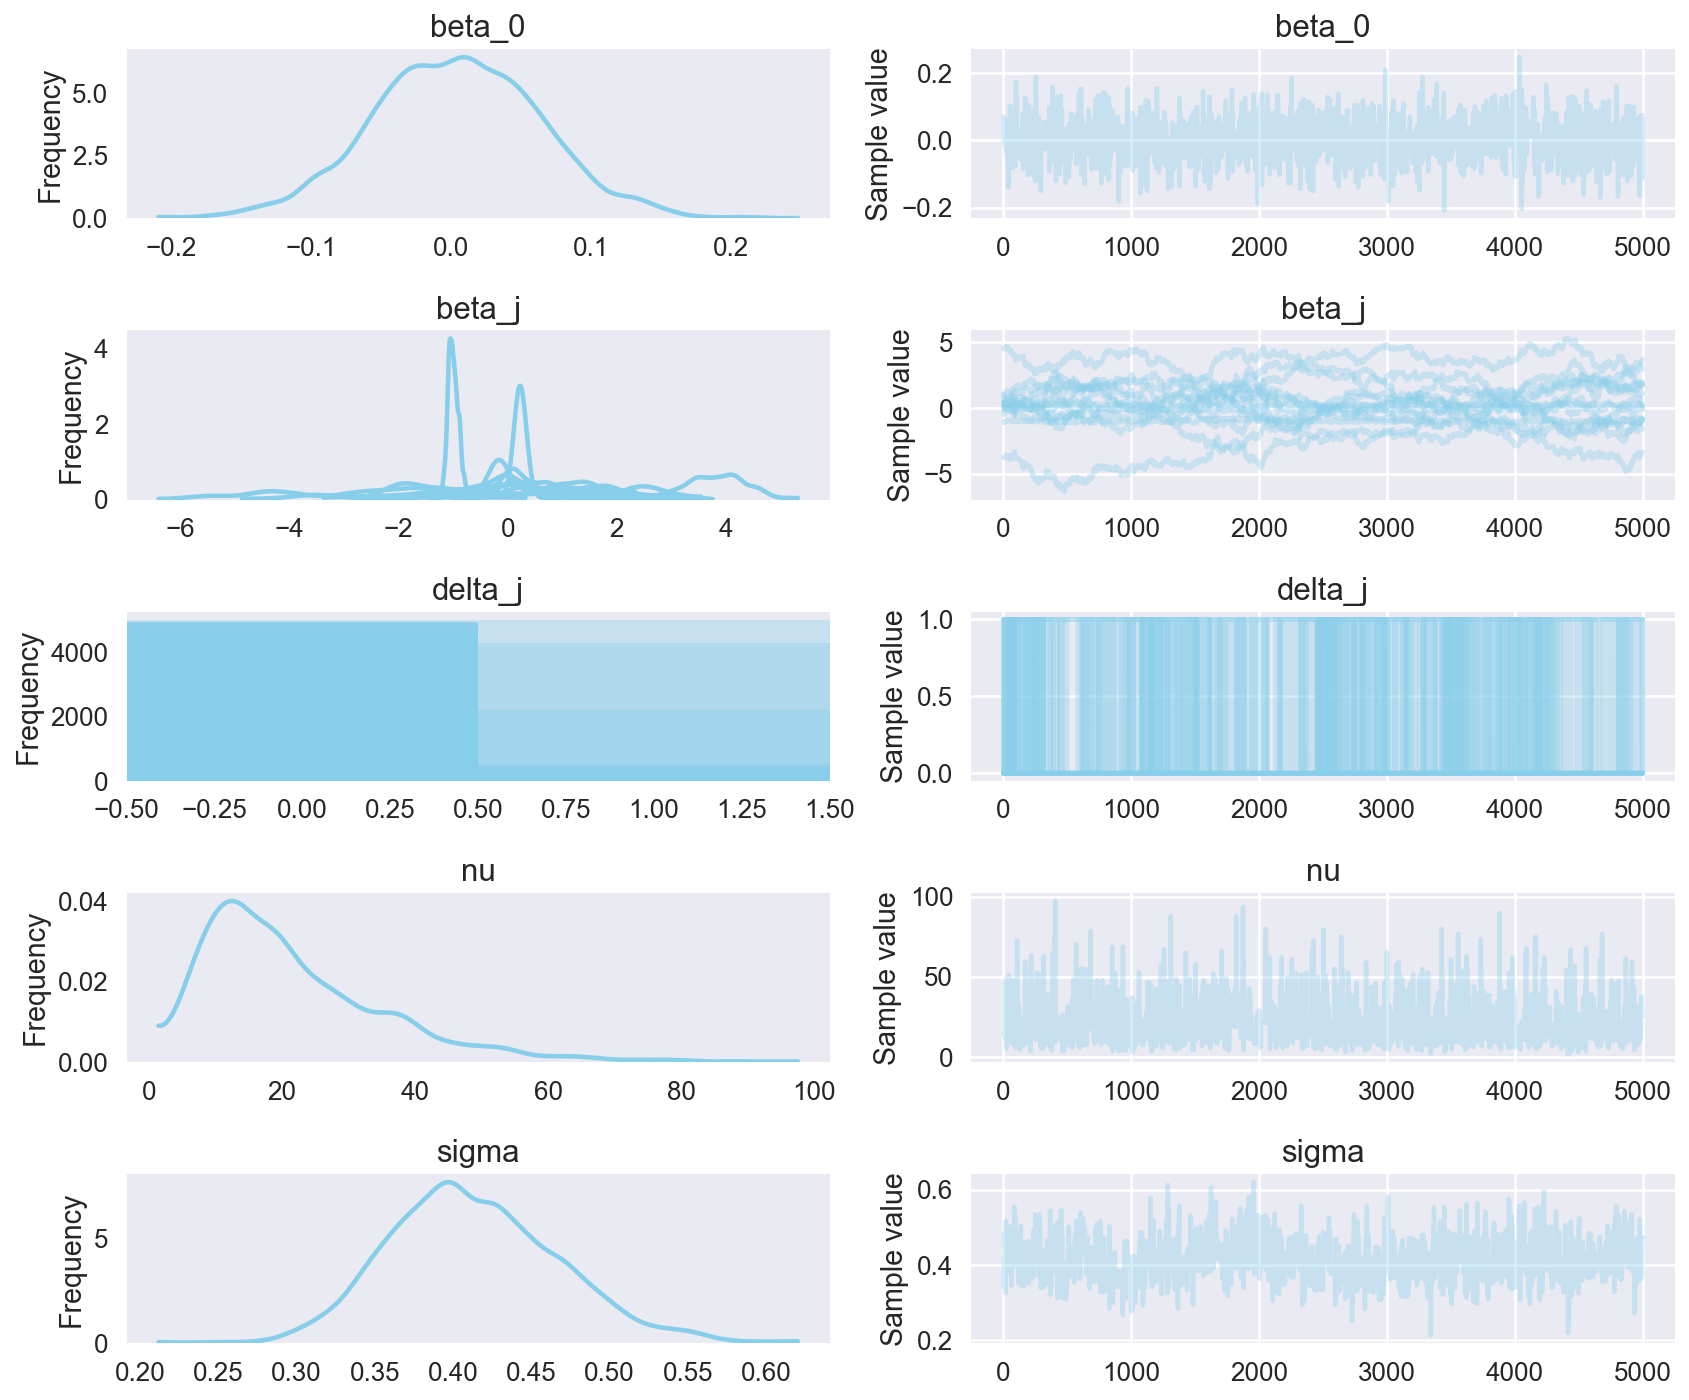

In [23]:
print(pm.df_summary(trace))
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13d565450>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13f649150>], dtype=object)

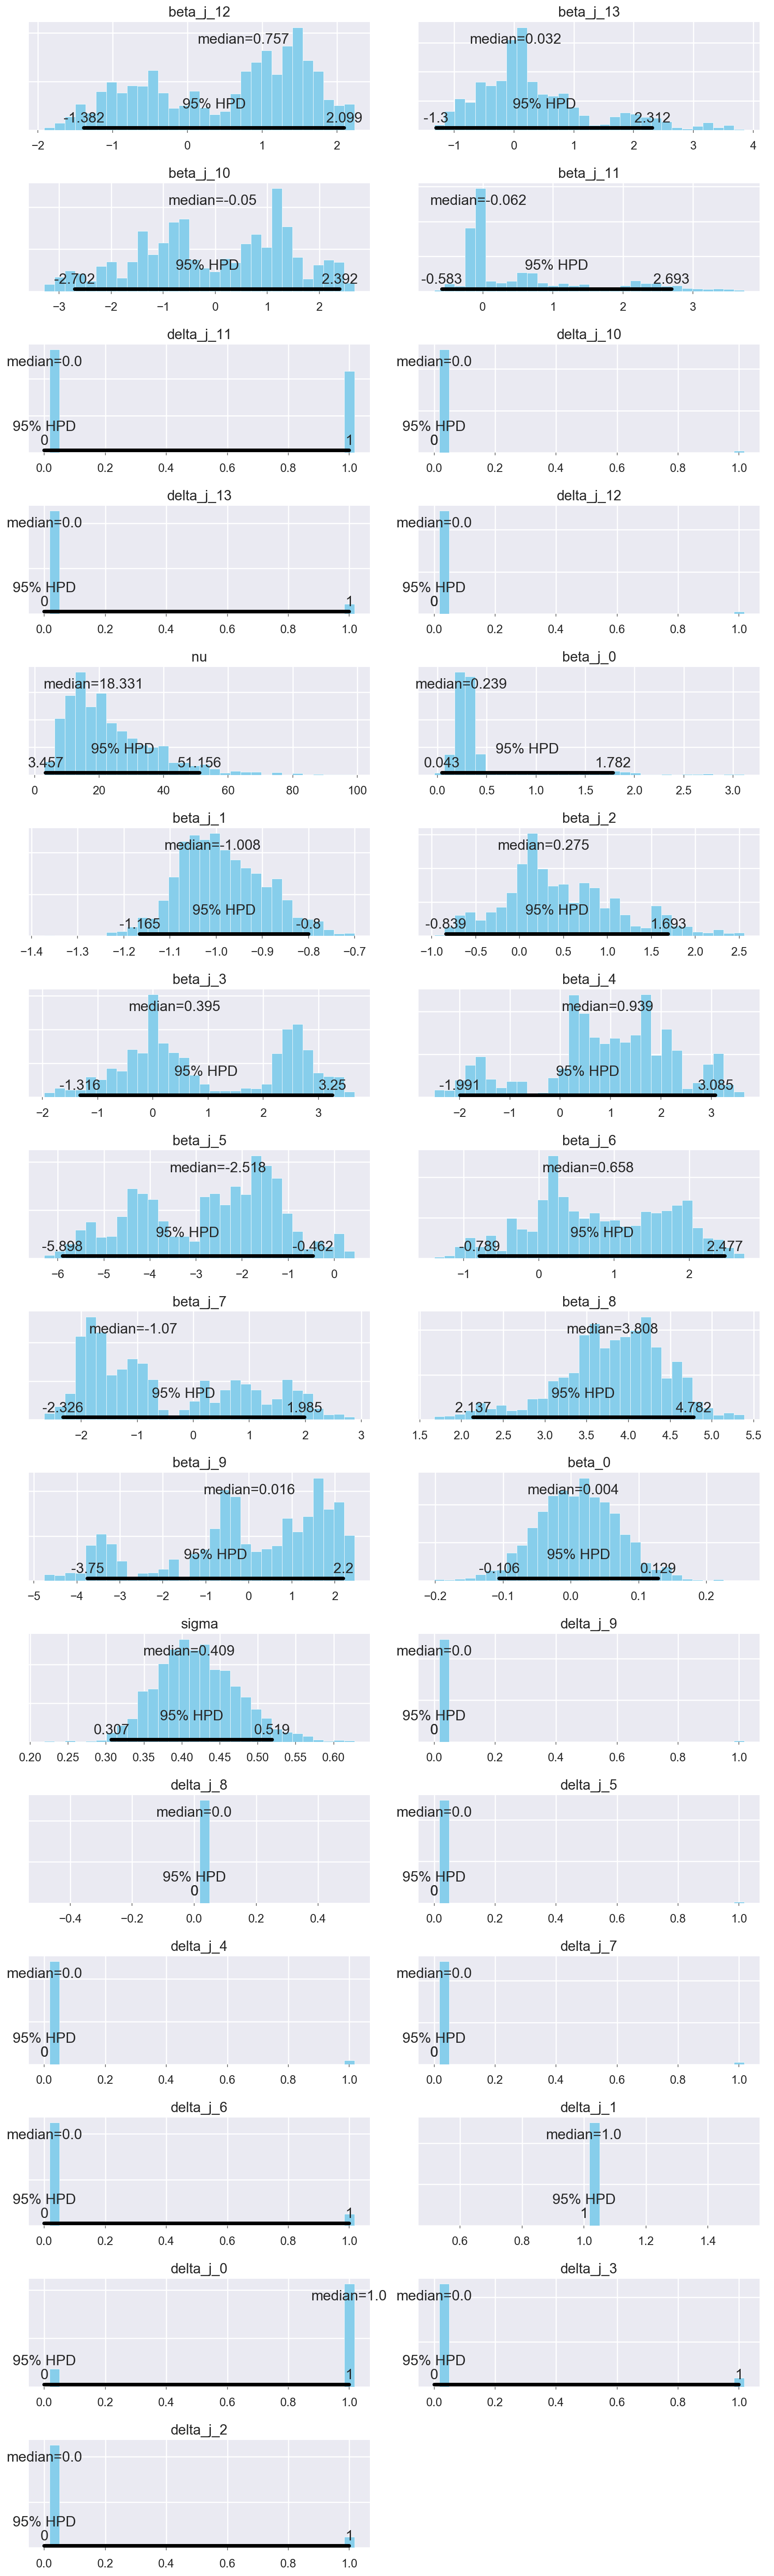

In [24]:
pm.plot_posterior(trace, point_estimate="median")

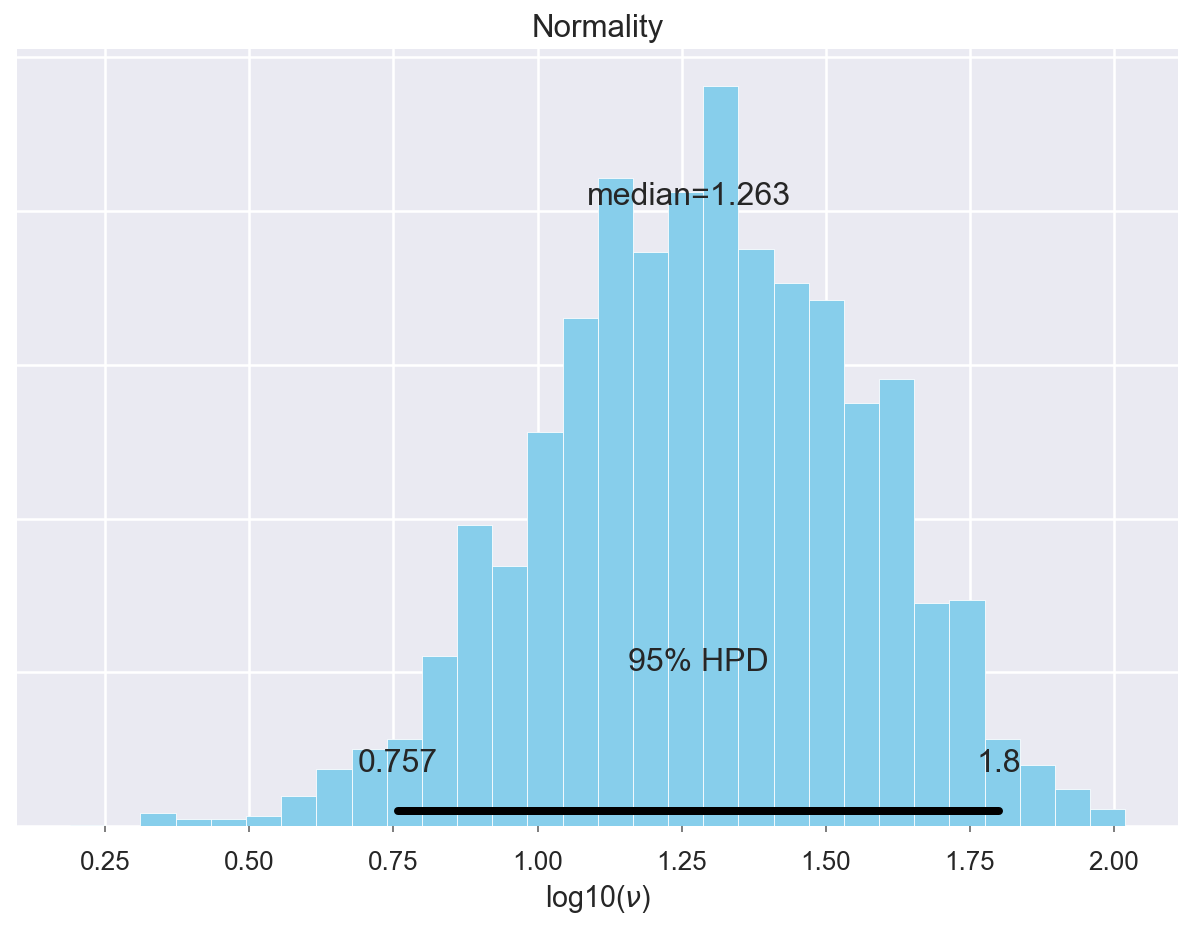

In [25]:
normality = np.log10(trace["nu"])
ax = pm.plot_posterior(normality, point_estimate="median")
ax.set_title("Normality")
ax.set_xlabel(r"log10($\nu$)")

### Use `sd=1` on `beta` priors

In [26]:
with pm.Model() as sd1_model:
    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, sd=1)
    beta_j = pm.Normal("beta_j", mu=0, sd=1, shape=n_cols)
    delta_j = pm.Bernoulli("delta_j", 0.5, shape=n_cols)
    
    theta = beta_0 + tt.dot(delta_j * beta_j, zx.T)
    
    nu = pm.Gamma("nu", 2, .01)
    sigma = pm.HalfCauchy("sigma", 25)
    
    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=theta, sd=sigma, observed=zy)
    
    # Sample
    trace = pm.sample(5000)

burn_in = 2000
trace = trace[burn_in:]

Assigned NUTS to beta_0
Assigned NUTS to beta_j
Assigned BinaryGibbsMetropolis to delta_j
Assigned NUTS to nu_log_
Assigned NUTS to sigma_log_
100%|██████████| 5000/5000 [04:17<00:00, 19.40it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14c189890>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14c4bbb10>]], dtype=object)

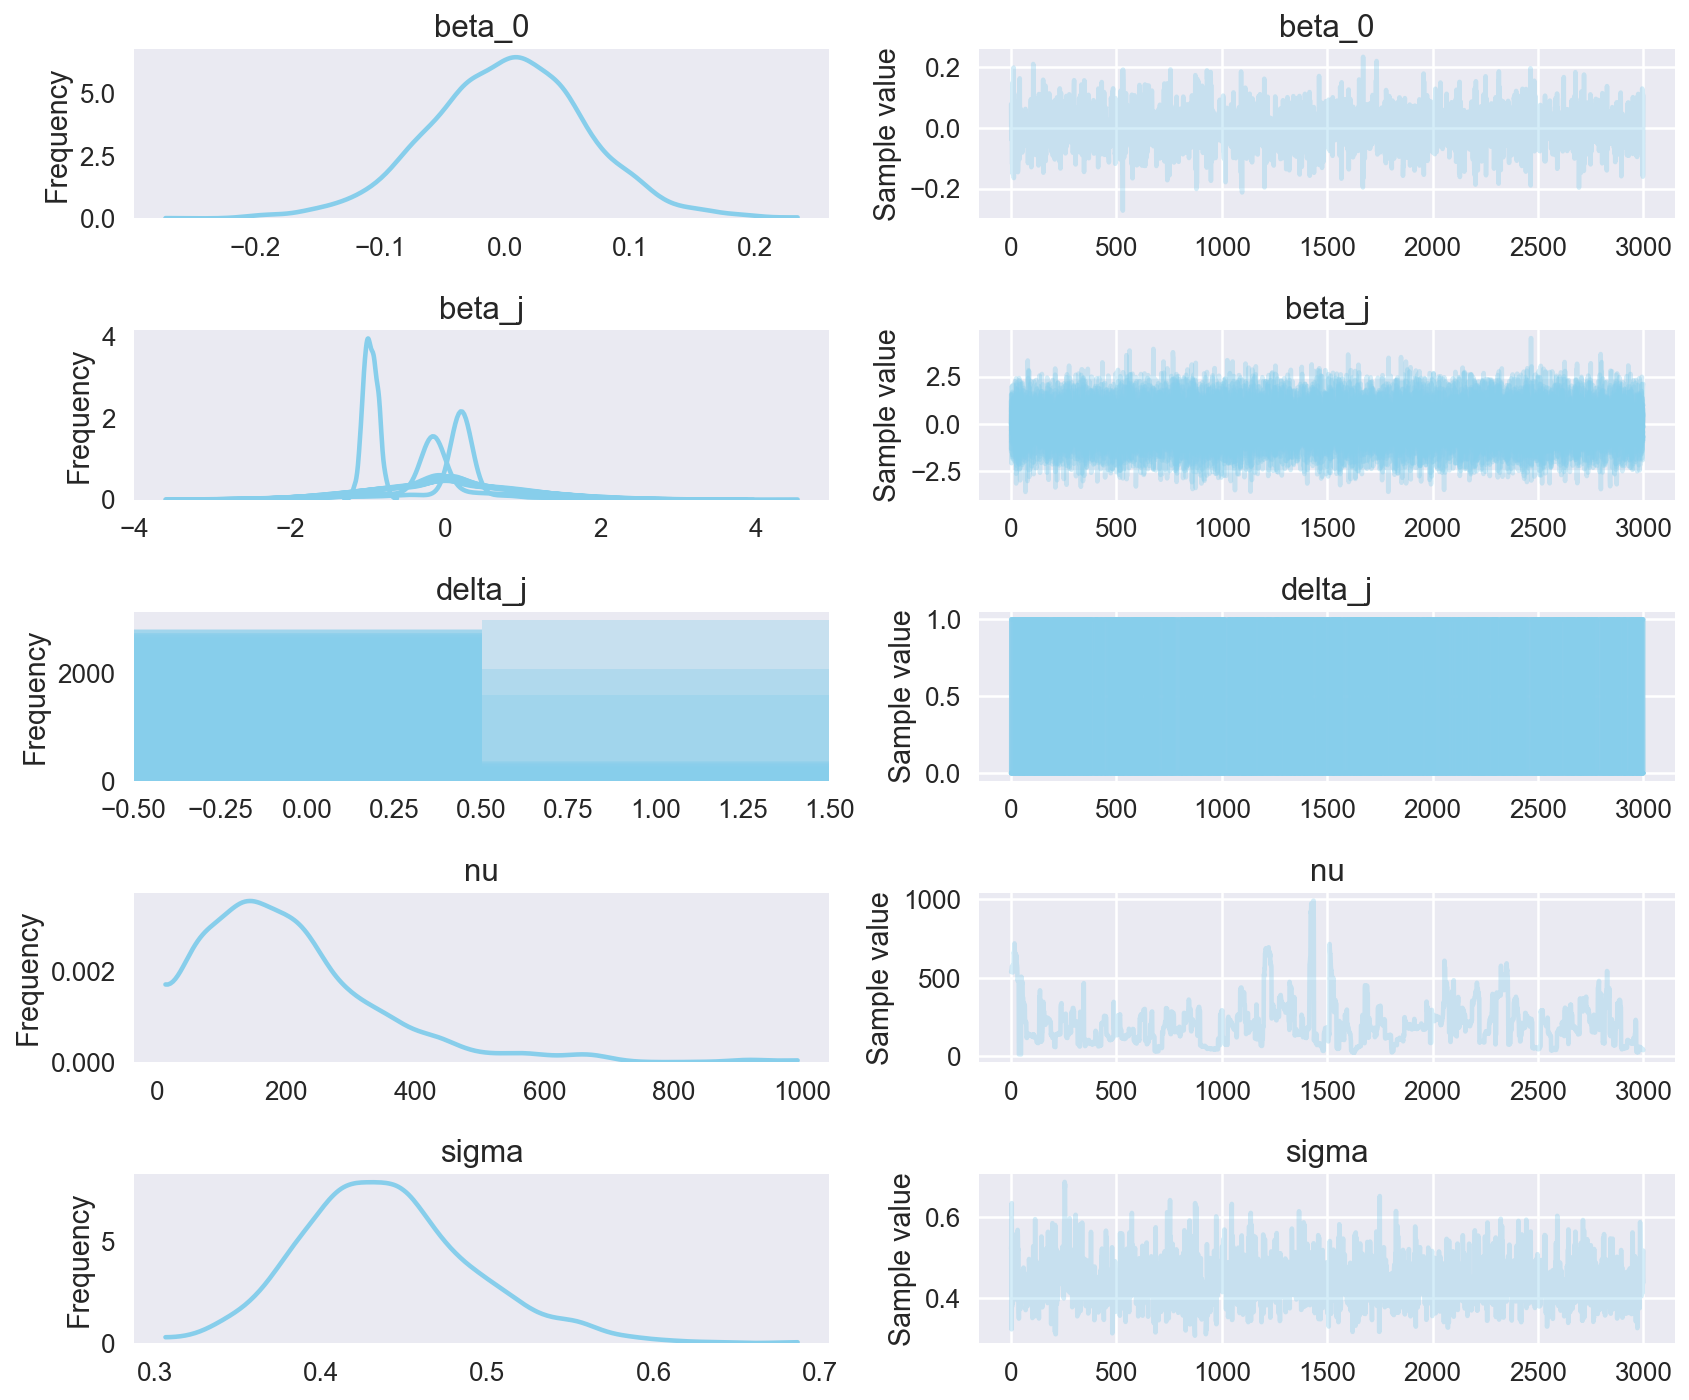

In [27]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14c6db610>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x14adf5cd0>], dtype=object)

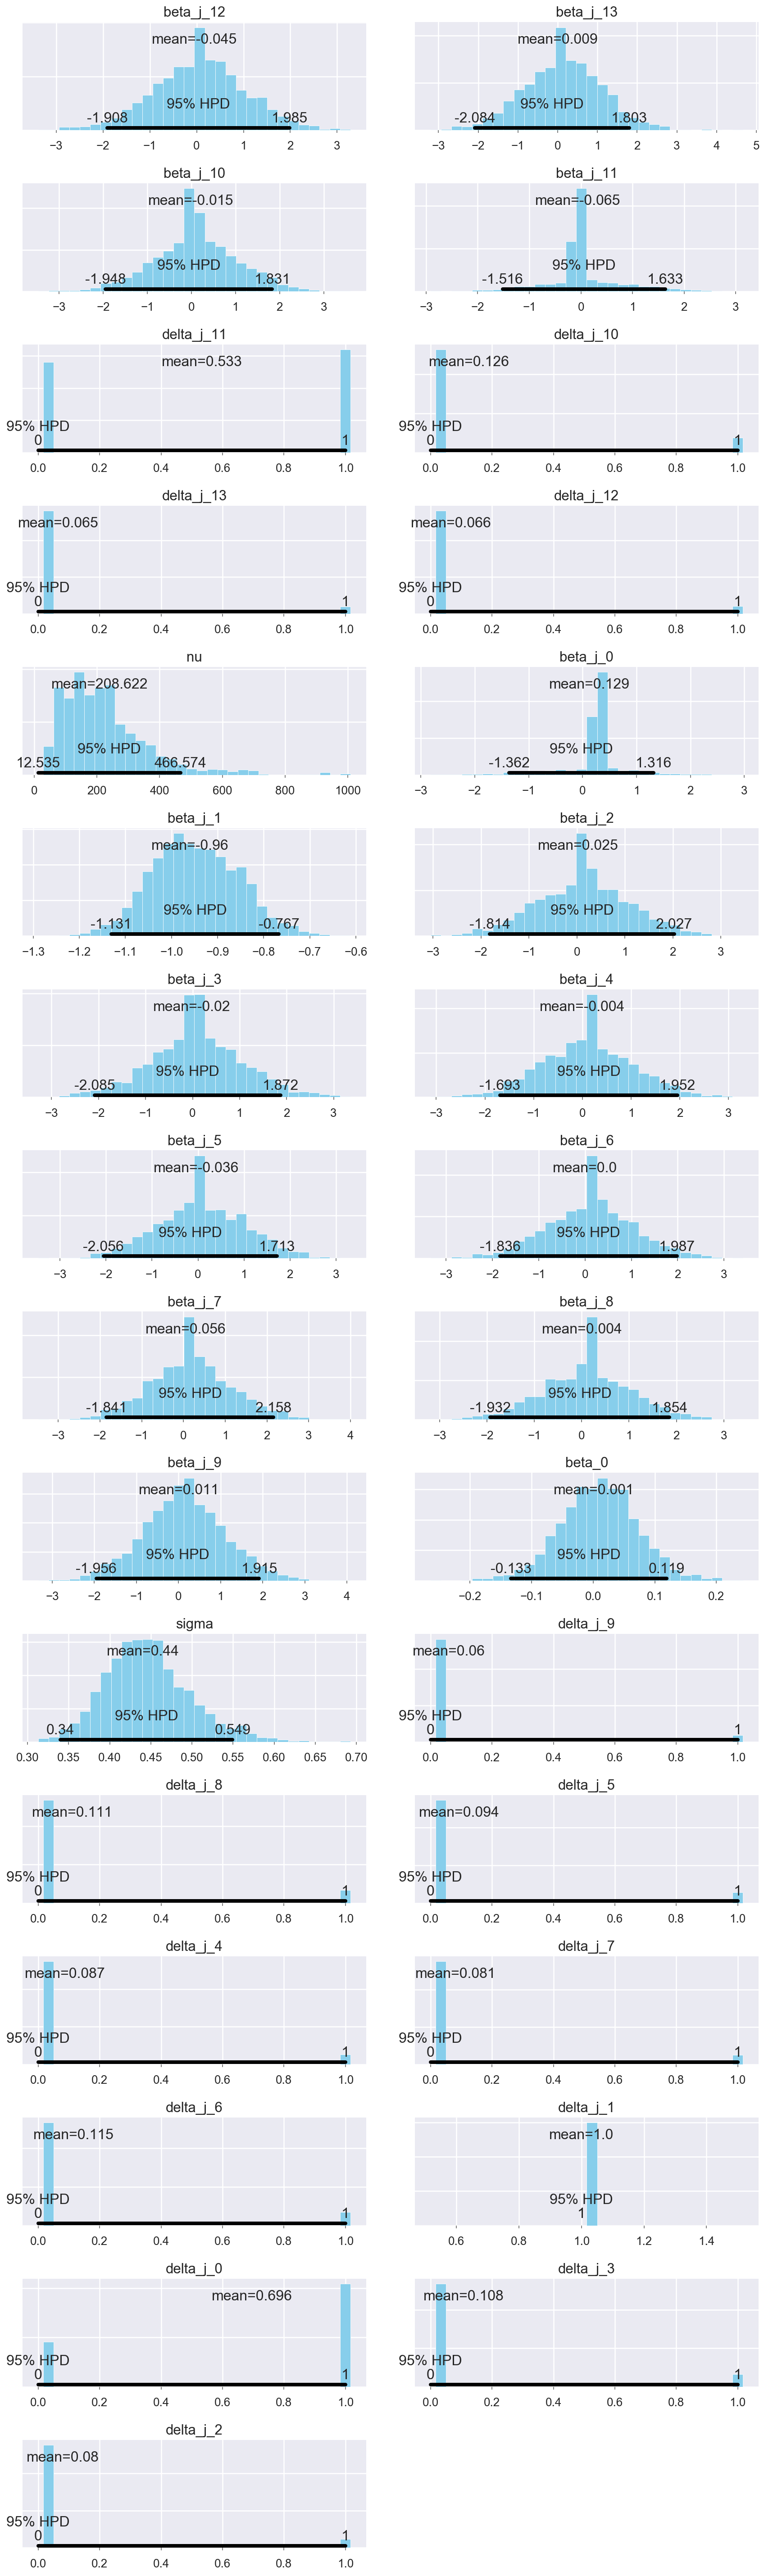

In [28]:
pm.plot_posterior(trace, point_estimate="median")

### Use `sd=10` on `beta` priors

In [29]:
with pm.Model() as sd10_model:
    beta_0 = pm.Normal("beta_0", mu=0, sd=10)
    beta_j = pm.Normal("beta_j", mu=0, sd=10, shape=n_cols)
    delta_j = pm.Bernoulli("delta_j", 0.5, shape=n_cols)
    
    theta = beta_0 + tt.dot(delta_j * beta_j, zx.T)
    
    nu = pm.Gamma("nu", 2, .1)
    sigma = pm.HalfCauchy("sigma", 25)
    
    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=theta, sd=sigma, observed=zy)
    
    # Sample
    trace = pm.sample(5000)

burn_in = 2000
trace = trace[burn_in:]

Assigned NUTS to beta_0
Assigned NUTS to beta_j
Assigned BinaryGibbsMetropolis to delta_j
Assigned NUTS to nu_log_
Assigned NUTS to sigma_log_
100%|██████████| 5000/5000 [15:56<00:00,  5.23it/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x157facfd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x158480450>]], dtype=object)

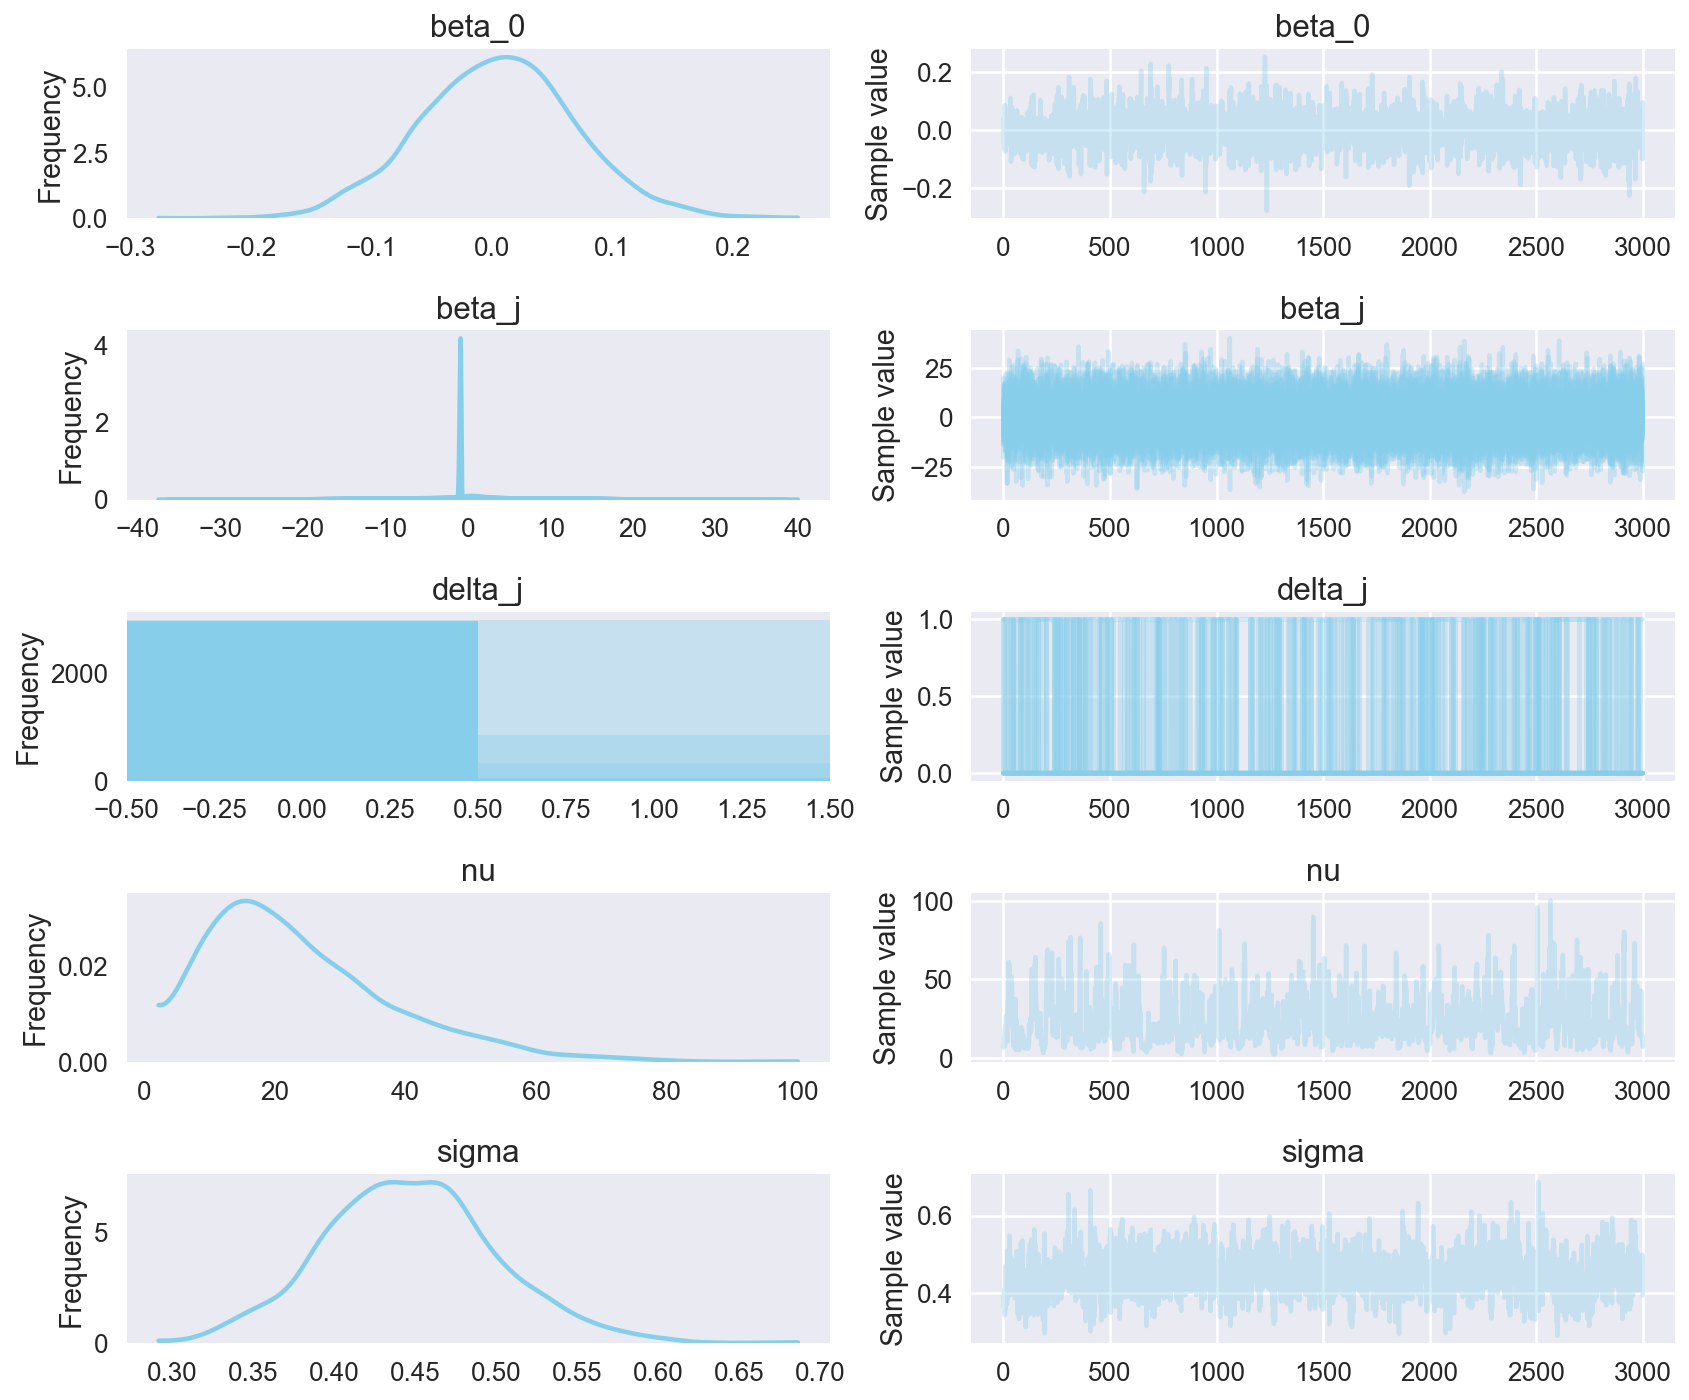

In [30]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1586791d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x15a13a510>], dtype=object)

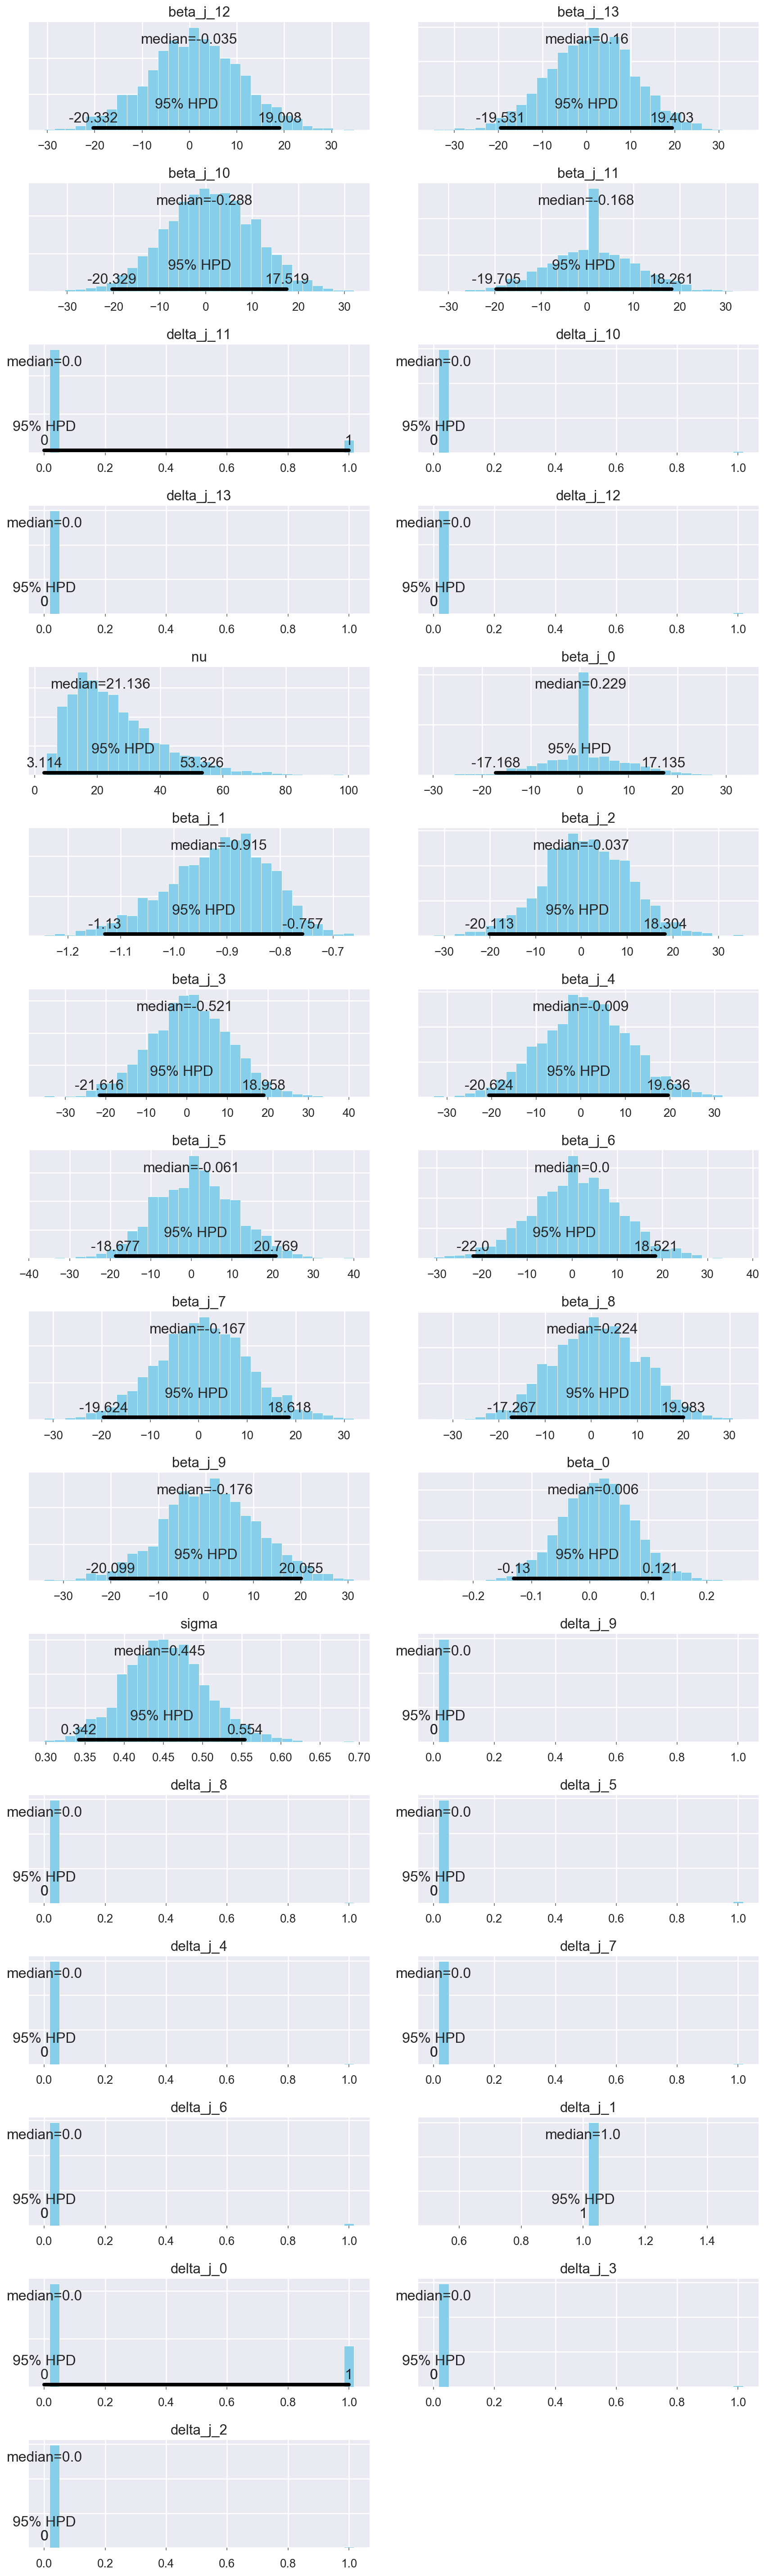

In [31]:
pm.plot_posterior(trace, point_estimate="median")

### Variable Selection with Hierarchical Shrinkage

> But if previous knowledge is weak, then the uncertainty should be expressed in the prior. This is an underlying mantra of the Bayesian approach: Any uncertainty should be expressed in the prior. Thus, if you are not sure what the value of σβ should be, you can estimate it and include a higher-level distribution to express your prior uncertainty. 

In [32]:
X = df[["Spend", "PrcntTake", "StuTeaRat", "Salary"]]
X.corr()

,Spend,PrcntTake,StuTeaRat,Salary
Spend,1.000000,0.592627,-0.371025,0.869802
PrcntTake,0.592627,1.000000,-0.213054,0.616780
StuTeaRat,-0.371025,-0.213054,1.000000,-0.001146
Salary,0.869802,0.616780,-0.001146,1.000000


In [33]:
zx_shrink = ((X - X.mean().values) / X.std().values).values
zx_shrink[:5]

array([[-1.10086058, -1.0178453 ,  0.15090313, -0.62022479],
       [ 2.24370805,  0.4394222 ,  0.32739801,  2.20863394],
       [-0.82716069, -0.30789447,  1.07750128, -0.44669273],
       [-1.06123647, -1.09257697,  0.10677941, -0.99219944],
       [-0.6701318 ,  0.36469053,  3.15131619,  1.05180963]])

In [36]:
n_shrink = 4
with pm.Model() as shrink_model:
    beta_0 = pm.Normal("beta_0", mu=0, sd=2)
    
    sigma_b = pm.HalfCauchy("sigma_b", 25)
    beta_j = pm.StudentT("beta_j", nu=1, mu=0, sd=sigma_b, shape=n_shrink)
    delta_j = pm.Bernoulli("delta_j", .5, shape=n_shrink)
    
    theta = beta_0 + tt.dot(delta_j * beta_j, zx_shrink.T)
    nu = pm.Exponential("nu", 1.0 / 30)  # From the book
    sigma = pm.HalfCauchy("sigma", 25)
    
    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=theta, sd=sigma, observed=zy)
    # Sample
    trace = pm.sample(5000)
    
burn_in = 2000
trace = trace[burn_in:]

Assigned NUTS to beta_0
Assigned NUTS to sigma_b_log_
Assigned NUTS to beta_j
Assigned BinaryGibbsMetropolis to delta_j
Assigned NUTS to nu_log_
Assigned NUTS to sigma_log_
100%|██████████| 5000/5000 [18:40<00:00, 10.81it/s]  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1629a2910>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x16371c110>]], dtype=object)

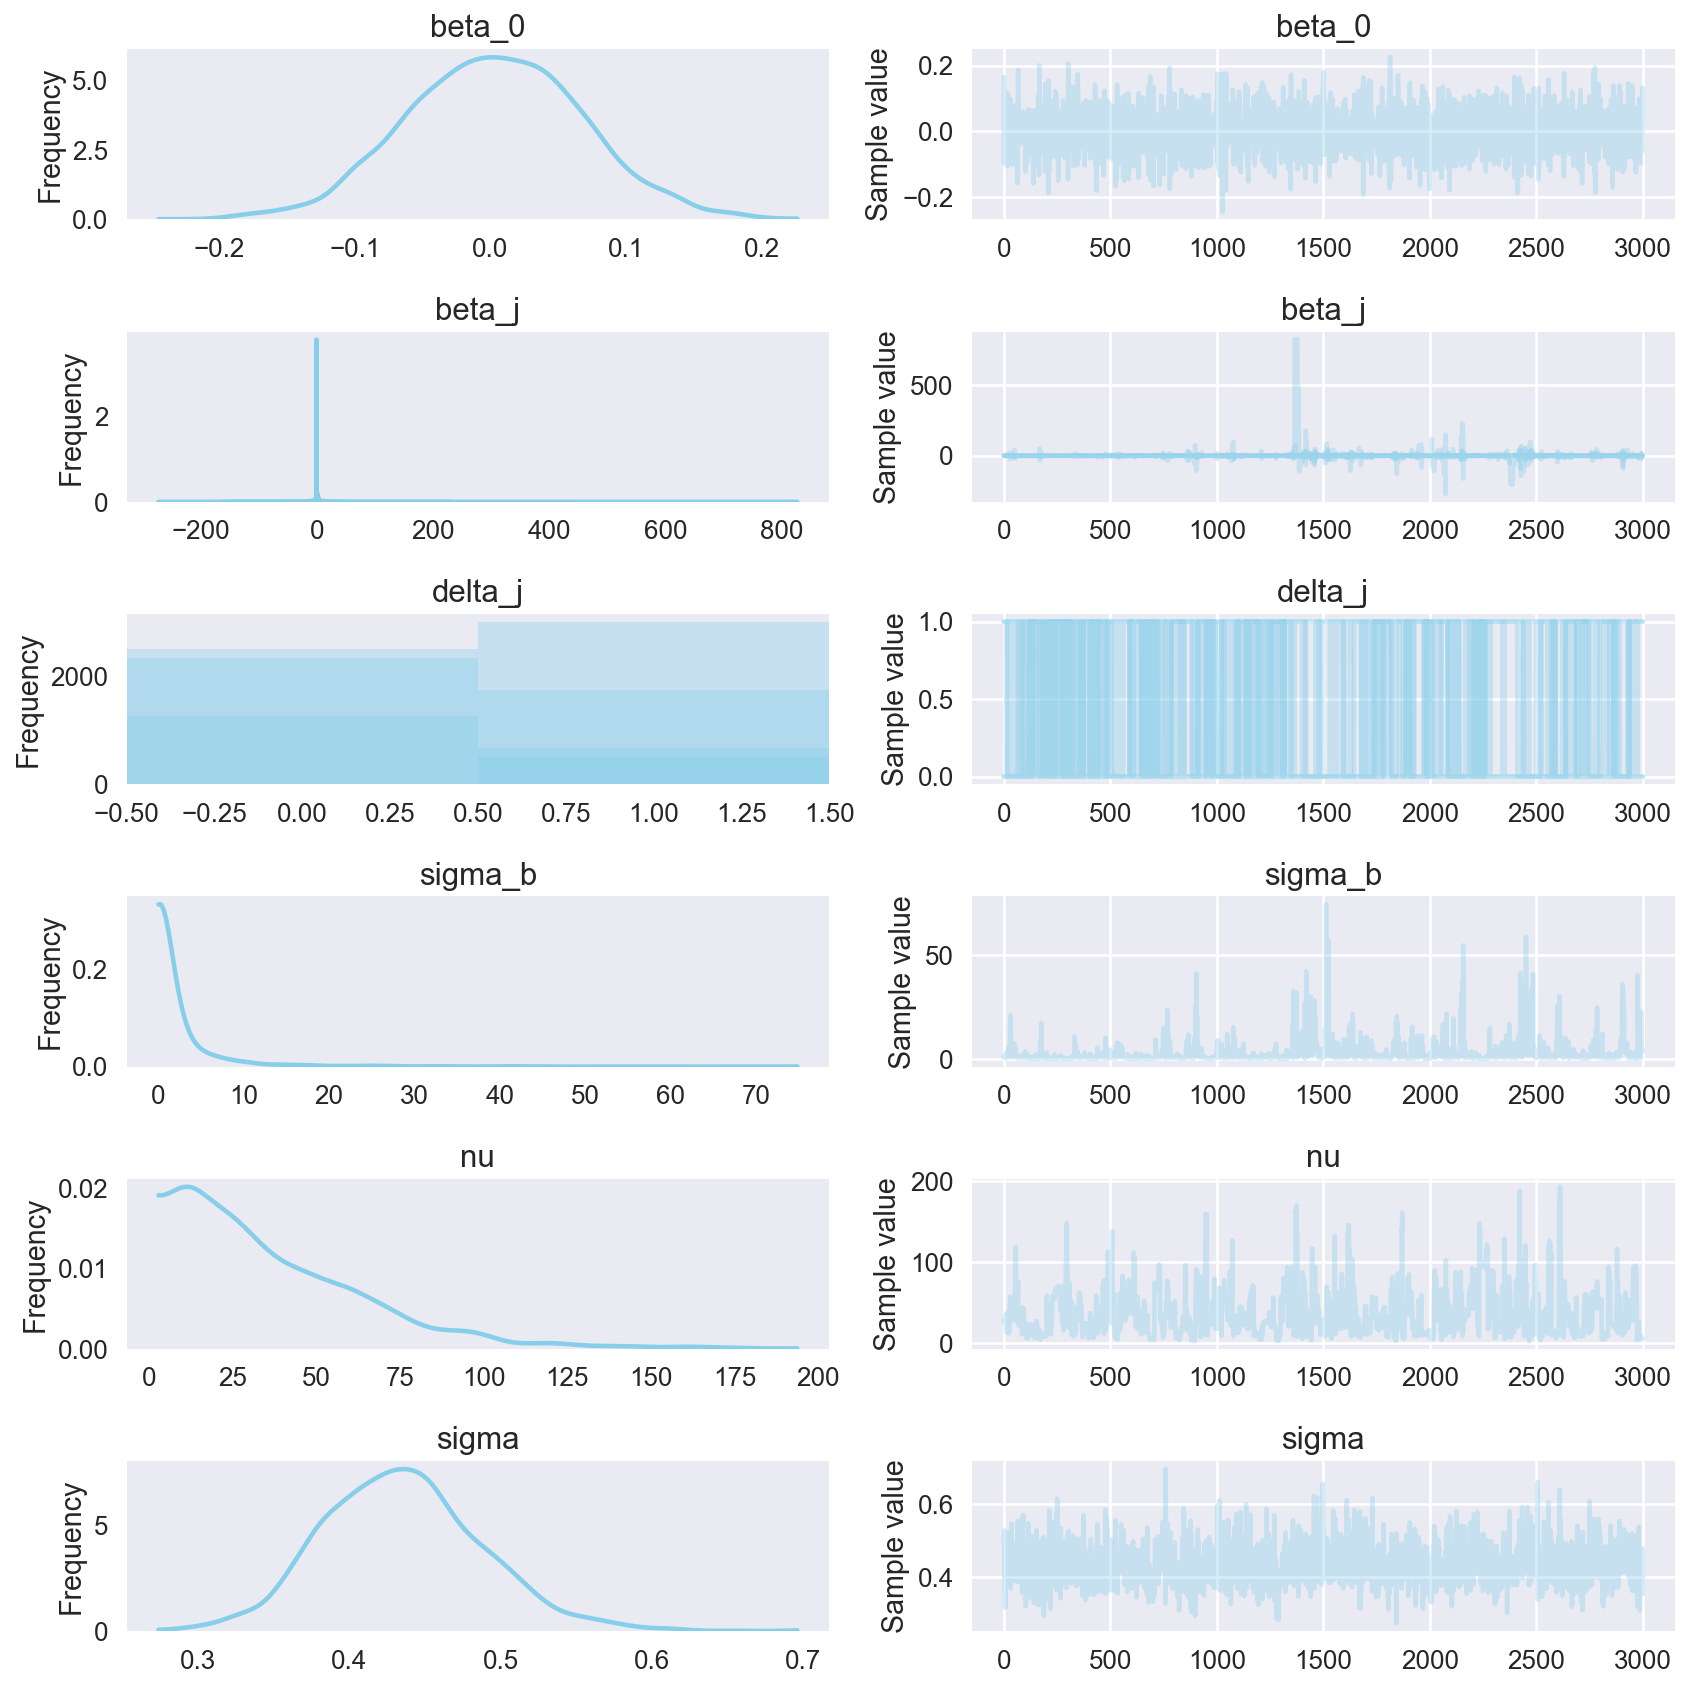

In [37]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15b030e50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x165409850>], dtype=object)

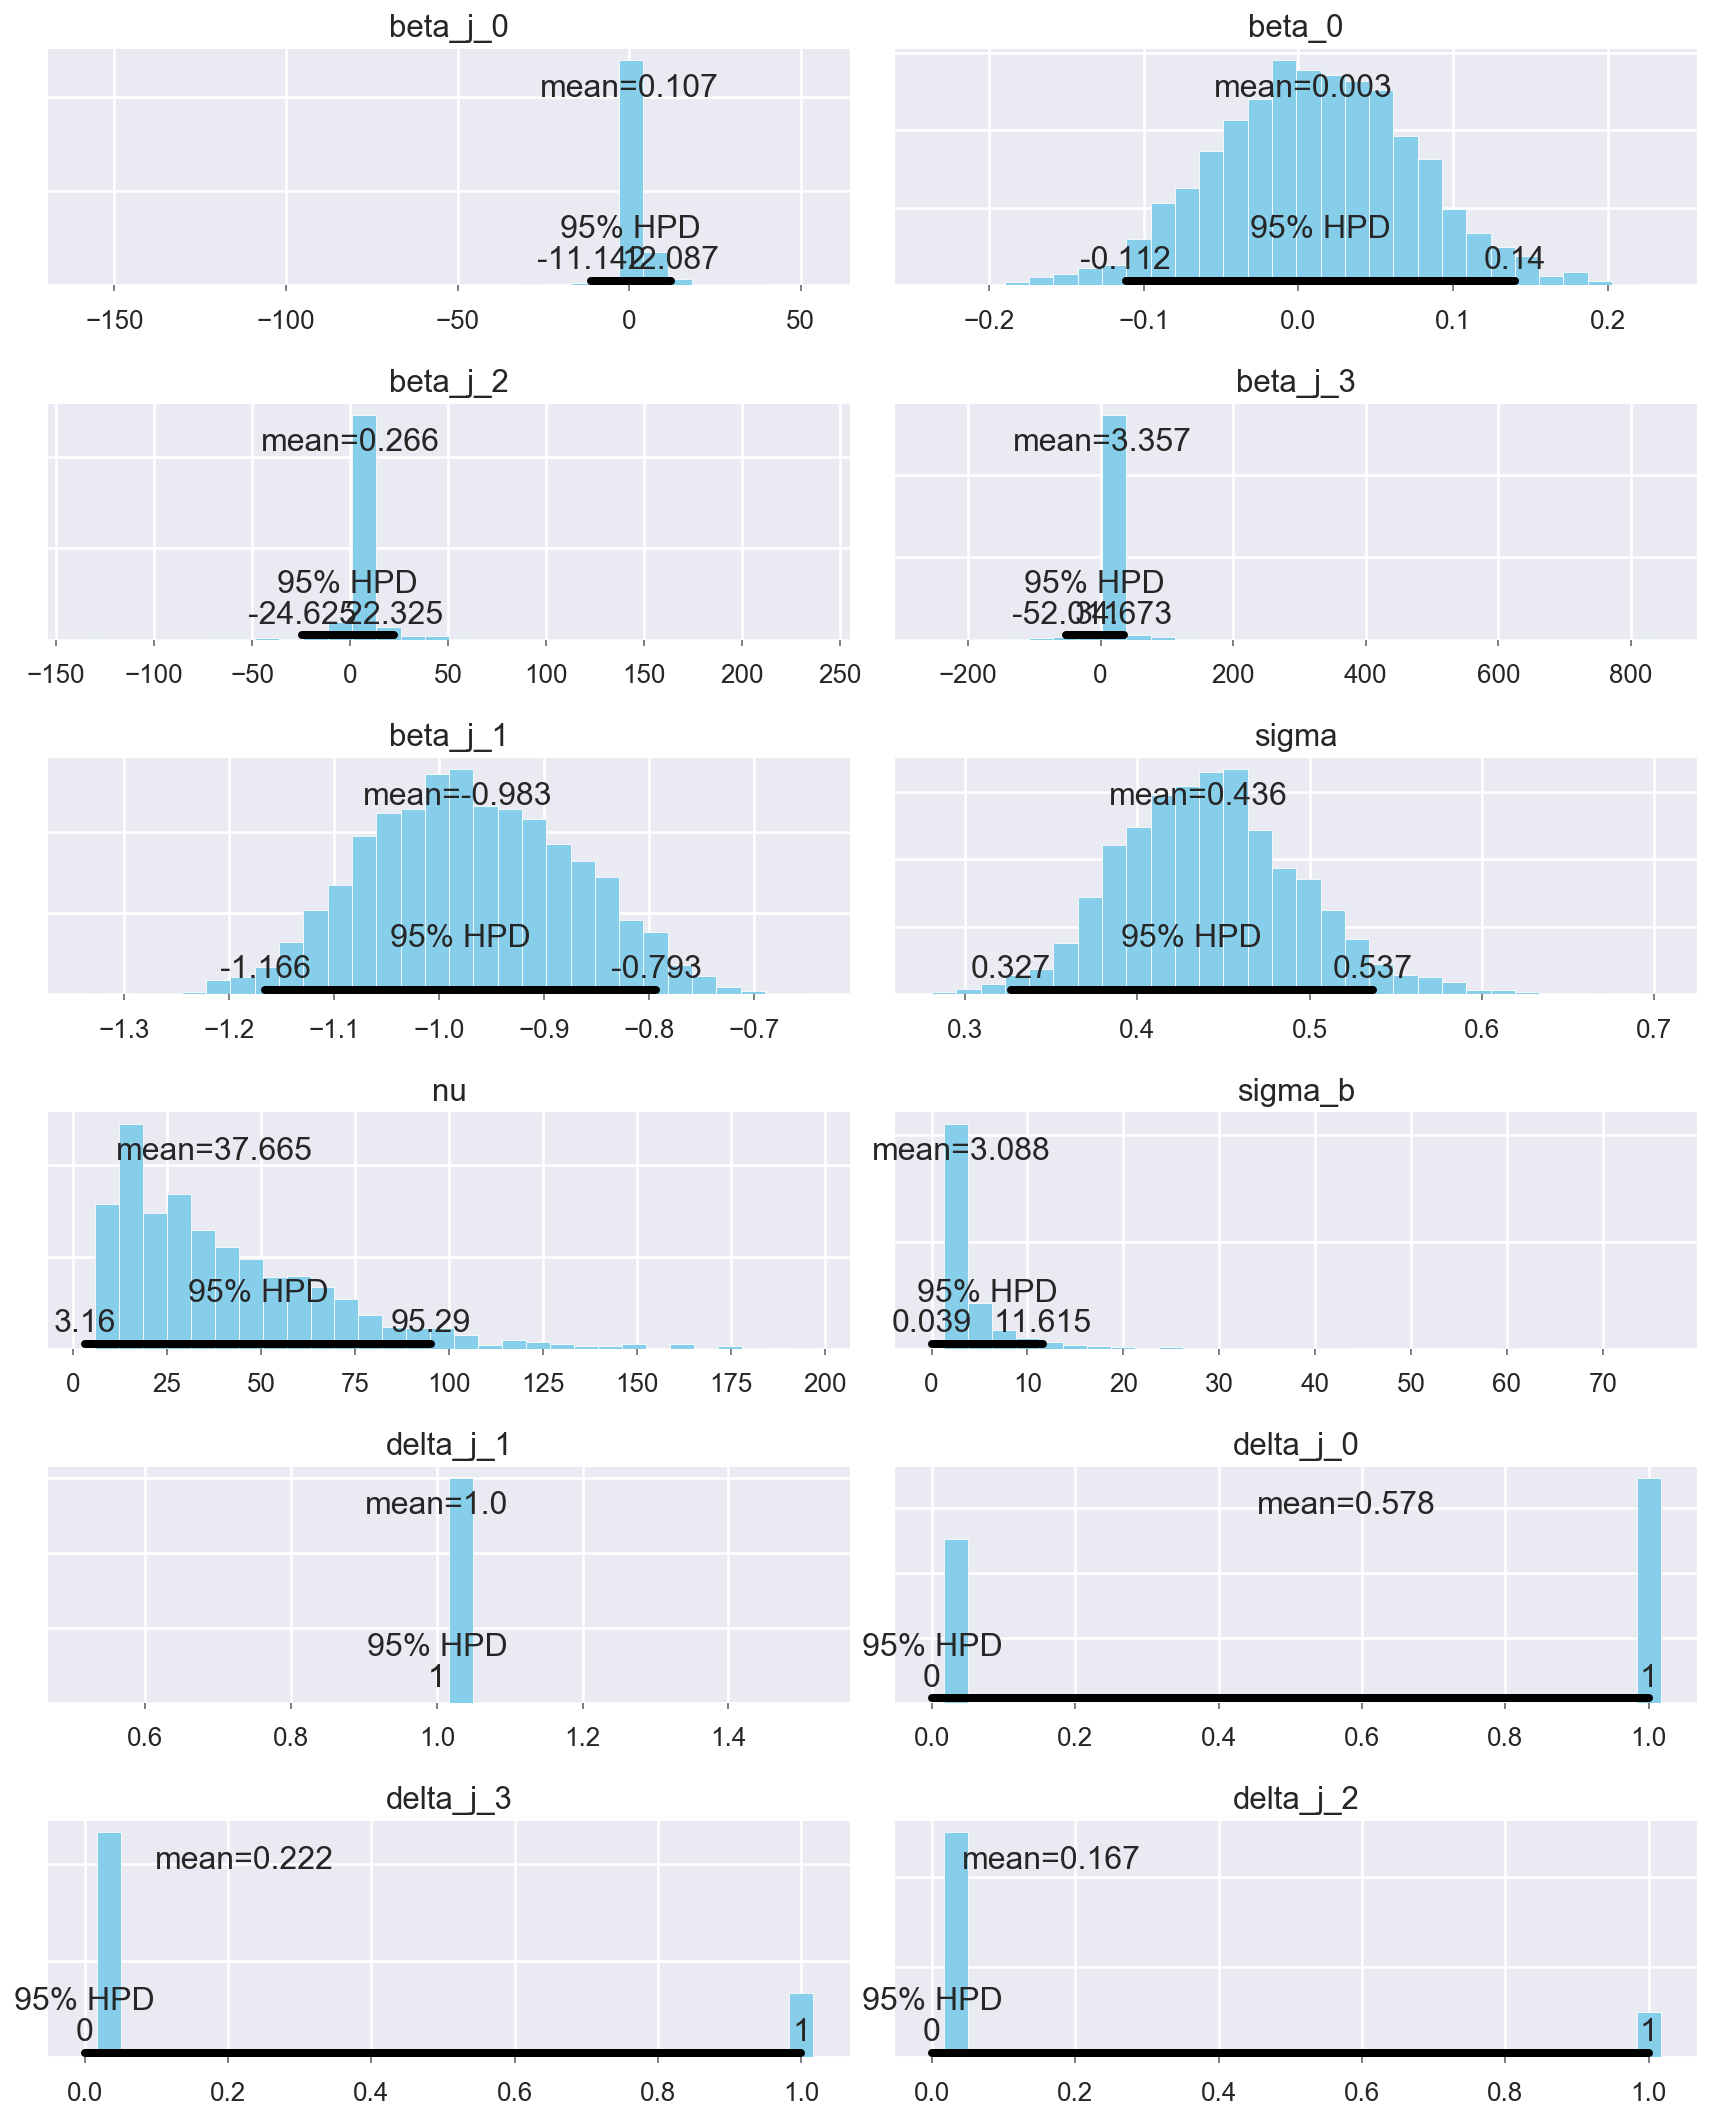

In [38]:
pm.plot_posterior(trace)